# AlexNet - flower数据集
网络结构：5个卷积，3个全连接
[图片输入(3\*227\*227)] <br>
--> { [卷积+ReLU(96\*55\*55)]-[池化(96\*27\*27] }$_2$ <br>
--> { [卷积+ReLU(256\*27\*27)]-[池化(256\*13\*13] }$_2$ <br>
--> {[卷积+ReLU(384\*13\*13)]} <br>
--> {[卷积+ReLU(384\*13\*13)]} <br>
--> {[卷积+ReLU(256\*13\*13)]} <br>
--> {[池化(256\*6\*6)]} <br>
--> {[全连接(256\*6\*6==4096)+ReLU]} <br>
--> {{[全连接(4096==4096)+ReLU]} <br>
--> {{[全连接(4096==1000)]}

## 网络训练

### 挂载云盘，使用数据集

In [1]:
from google.colab import drive
drive.mount('/gdrive') ## mount drive

Mounted at /gdrive


### 加载各种扩展库

In [2]:
import os
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import numpy as np
import torch.optim as optim
from tqdm.notebook import tqdm

### AlexNet网络准备

In [3]:
class AlexNet(nn.Module):  
    def __init__(self, num_classes=1000, init_weights=False):
        super(AlexNet, self).__init__()
        
        self.conv = nn.Sequential( 
            nn.Conv2d(in_channels=3,out_channels=48, kernel_size=11, stride=4), 
            nn.ReLU(inplace=True),  # 不用在产生新的变量，原值覆盖
            nn.MaxPool2d(kernel_size=3, stride=2), 
            
            nn.Conv2d(in_channels=48, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=128*6*6, out_features=2048), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(in_features=2048, out_features=2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(2048, num_classes),
        )

        # if init_weights:
        #     self._initialize_weights()

    def forward(self, img):
        feature = self.conv(img)
        feature = torch.flatten(feature, start_dim=1)
        output = self.fc(feature) # 压成一维的形式，送入全连接层
        return output
    
    # # # 网络权重初始化，网络在被构建时会自动初始化
    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    #             if m.bias is not None:
    #                 nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.Linear):
    #             nn.init.normal_(m.weight, 0, 0.01)
    #             nn.init.constant_(m.bias, 0)

### 设置网络函数，参数

In [4]:
# 打印现在正在用的cpu/gpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print("using {} device.".format(DEVICE))

# 训练次数
EPOCHS = 10 

# 构建模型
model =  AlexNet(num_classes=5).to(DEVICE)

# 定义损失函数
criterion = nn.CrossEntropyLoss() 

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.0002)

using cuda device.


### 准备训练集，验证集
（数据集已提前分好类）

In [5]:
# 从PIL图像 --> Tensor 
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(227),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(
                                      (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
    "val": transforms.Compose([transforms.Resize((227, 227)), 
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])}
# 数据集的位置
file = '/gdrive/My Drive/Pytorch/flower_data/' 

# train_load 设置
train_dataset = datasets.ImageFolder(root=file+"train",
                                     transform=data_transform["train"])
train_num = len(train_dataset)
batch_size = 32

# number of workers[暂时理解为可以加快速度，但内存消耗大]
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=nw)

# Validate_load 设置
validate_dataset = datasets.ImageFolder(root=file+"val",
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=4, 
                                              shuffle=False,
                                              num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num,
                                                                        val_num))

Using 2 dataloader workers every process
using 3306 images for training, 364 images for validation.


### 创建json文件，用于图像预测

In [6]:
# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx

# 把key, value交换，因为最后我们给出数字，返回名称
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open(file+'class_indices.json', 'w') as json_file:
    json_file.write(json_str)

### 构建训练函数

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    batch_total_loss = 0.0
    num_batch = len(train_loader) 

    train_bar = tqdm(train_loader) #加载了一个进度条，要用到循环里面去

    for batch_idx, (data, label) in enumerate(train_bar):
        data, label = data.to(DEVICE), label.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, label)

        loss.backward()
        optimizer.step()

        batch_total_loss += loss.item()

        # print statistics
        train_bar.desc = "train epoch{} \tloss:{:.3f}".format(epoch+1, loss)
    print('avg_train_loss: %.3f'% (batch_total_loss/num_batch))

### 构建验证函数

In [8]:
def val(model, device, test_loader, epoch):
    model.eval()
    num_acc = 0.0  # accumulate accurate number / epoch

    with torch.no_grad():
        val_bar = tqdm(validate_loader)
        
        for val_data, val_label in val_bar:
            val_data, val_label = val_data.to(DEVICE), val_label.to(DEVICE)

            outputs = model(val_data)

            # 找到概率最大的下标
            predict_y = torch.max(outputs, dim=1)[1]

            # torch.eq()比较是否相同，返回T/F
            num_acc += torch.eq(predict_y, val_label).sum().item() 

            val_bar.desc = "Validate: "

    val_accurate = num_acc / val_num
    print('[epoch %d] val_accuracy: %.3f' % (epoch + 1, val_accurate))


### 主函数

In [9]:
def main():
    for epoch in range(EPOCHS):
        train(model, DEVICE, train_loader, optimizer, epoch)
        val(model, DEVICE, validate_loader, epoch)
    print('Finished Training')

    # 网络保存
    save_path = '/gdrive/My Drive/Pytorch/AlexNet.pth'
    torch.save(model.state_dict(), save_path)

if __name__ == '__main__':  #主函数入口
    main()


avg_train_loss: 1.531



[epoch 1] val_accuracy: 0.327



avg_train_loss: 1.258



[epoch 2] val_accuracy: 0.519



avg_train_loss: 1.128



[epoch 3] val_accuracy: 0.571



avg_train_loss: 1.032



[epoch 4] val_accuracy: 0.588



avg_train_loss: 0.997



[epoch 5] val_accuracy: 0.604



avg_train_loss: 0.958



[epoch 6] val_accuracy: 0.648



avg_train_loss: 0.926



[epoch 7] val_accuracy: 0.640



avg_train_loss: 0.861



[epoch 8] val_accuracy: 0.654



avg_train_loss: 0.861



[epoch 9] val_accuracy: 0.695



avg_train_loss: 0.815



[epoch 10] val_accuracy: 0.684
Finished Training


## 预测

### 加载扩展库

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

### 输入图像处理

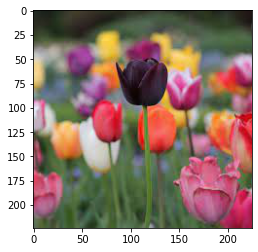

In [11]:
data_transform = transforms.Compose([transforms.Resize((227, 227)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), 
                                                          (0.5, 0.5, 0.5))])
# load image
img_path = '/gdrive/My Drive/Pytorch/flower_data/tulip.jpeg'
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
image = Image.open(img_path)
plt.imshow(image)

img = data_transform(image)  # img_tensor_size = C x H x W
# expand batch dimension 在第0个位置 1 x C x H x W, pytorch是按批次处理的
img = torch.unsqueeze(img, dim=0) 

### 给出预测结果

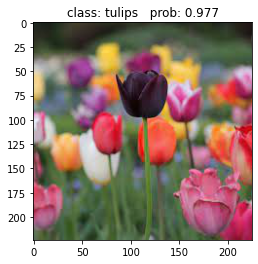

In [29]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 加载网络
model = AlexNet(num_classes=5).to(DEVICE)

# load model weights
weights_path =  '/gdrive/My Drive/Pytorch/AlexNet.pth'
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path))

# 预测
model.eval()
with torch.no_grad():
    # .cpu()是为了后面用numpy
    # squeeze掉batch dimension
    output = torch.squeeze(model(img.to(DEVICE))).cpu() 
    predict = torch.softmax(output, dim=0) # 给出每一类的概率值
    predict_cla = torch.argmax(predict).numpy() # 找到最大概率值的类

# 加载标签
json_path = '/gdrive/My Drive/Pytorch/flower_data/class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

json_file = open(json_path, "r")
class_indict = json.load(json_file)

# 给出预测结果
print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                              predict[predict_cla].numpy())
plt.title(print_res)
plt.imshow(image)